## Nakajo Storms: Selection of representative cases using Maximum Dissimilarity (MaxDiss) algorithm (Camus et al. 2011)

inputs required: 
  * Synthetic TC parameters that affect the site
  * number of representative cases to be selected using MaxDiss

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.storms import Extract_Circle
from teslakit.mda import MaxDiss_Simplified_NoThreshold
from teslakit.plotting.storms import Plot_Params_MDA_vs_Sim_scatter, Plot_Params_Hist_vs_Sim_scatter



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# load data and set parameters

# wave point longitude and latitude
pnt_lon = 167.5
pnt_lat = 9.75

# radius for TCs selection (º)
r1 = 14
r2 = 4

# MDA number of cases
num_sel_mda = 1000

xds_Nakajo = db.Load_TCs_Nakajo()  # Load Nakajo simulations
_, xds_TCs_r2_params_historical = db.Load_TCs_r2()  # historical TCs parameters inside radius 2


In [4]:
# dictionary with needed variable names
d_vns = {
    'longitude':'ylon_TC',
    'latitude':'ylat_TC',
    'time': 'yts',
    'pressure':'yCPRES',
}

# Extract TCs inside r2
_, xds_TCs_r2_params = Extract_Circle(xds_Nakajo, pnt_lon, pnt_lat, r2, d_vns)
print(xds_TCs_r2_params)


<xarray.Dataset>
Dimensions:        (storm: 12160)
Coordinates:
  * storm          (storm) int64 5 296 299 387 ... 999846 999877 999982 999986
Data variables:
    pressure_min   (storm) float64 988.1 961.0 998.7 ... 976.4 1.007e+03 998.5
    pressure_mean  (storm) float64 988.7 977.2 1.002e+03 ... 1.007e+03 1.001e+03
    velocity_mean  (storm) float64 172.6 21.28 17.16 89.95 ... 18.78 6.065 14.21
    gamma          (storm) float64 114.0 104.0 122.9 99.87 ... 94.51 107.9 130.4
    delta          (storm) float64 98.43 84.54 144.1 86.74 ... 113.7 114.5 170.3
    category       (storm) int64 1 3 1 1 2 4 0 2 0 0 1 ... 3 1 2 3 2 1 1 0 2 0 1
    dmin_date      (storm) float64 45.4 117.0 6.0 16.5 ... 0.0 114.0 0.0 24.0
    last_date      (storm) float64 54.4 183.0 162.0 90.0 ... 342.0 150.0 259.5
    index_in       (storm) int64 71 33 0 9 13 58 0 16 2 ... 13 26 19 3 0 31 0 0
    index_out      (storm) int64 77 46 10 16 27 72 4 30 ... 36 25 10 1 45 3 14
Attributes:
    point_lon:  167.5
    poi

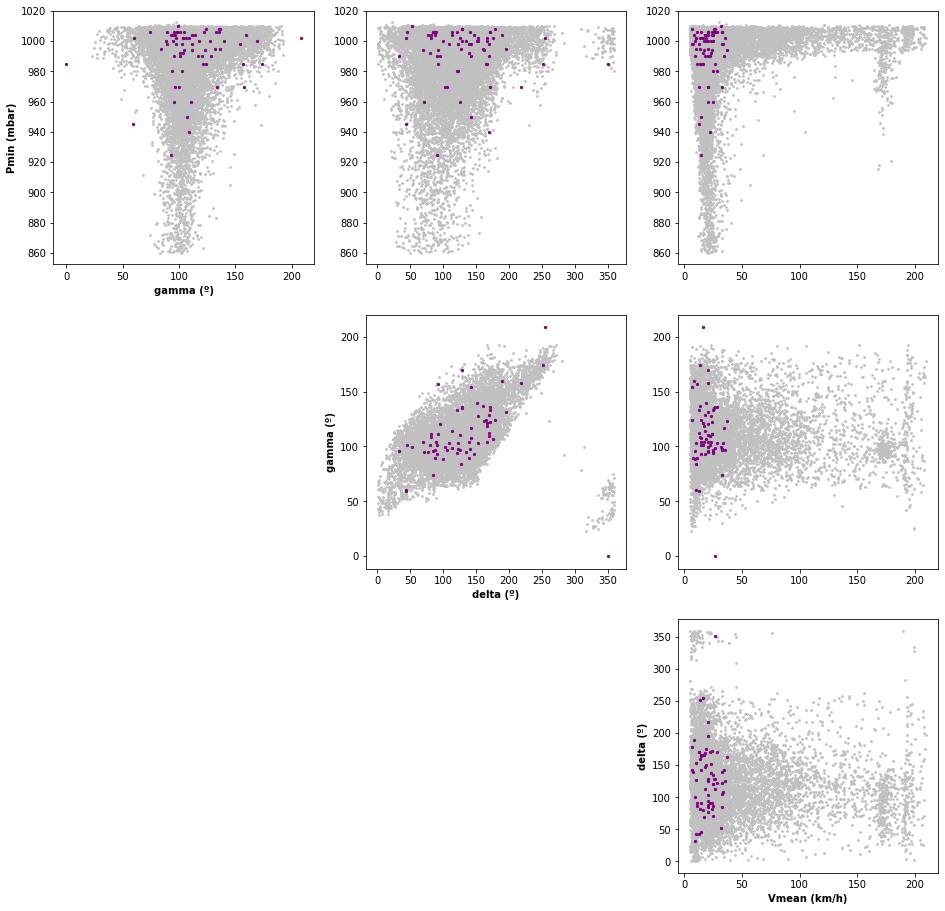

In [5]:
# Historical vs Nakajo Simulation: scatter plot parameters
Plot_Params_Hist_vs_Sim_scatter(xds_TCs_r2_params_historical, xds_TCs_r2_params)



## Historical TCs - MaxDiss classification

In [6]:
# --------------------------------------
# MaxDiss classification

# get simulated parameters  
pmean_s = xds_TCs_r2_params.pressure_mean.values[:]
pmin_s = xds_TCs_r2_params.pressure_min.values[:]
gamma_s = xds_TCs_r2_params.gamma.values[:]
delta_s = xds_TCs_r2_params.delta.values[:]
vmean_s = xds_TCs_r2_params.velocity_mean.values[:]

# subset, scalar and directional indexes
data_mda = np.column_stack((pmean_s, pmin_s, vmean_s, delta_s, gamma_s))
ix_scalar = [0,1,2]
ix_directional = [3,4]

# MDA
centroids = MaxDiss_Simplified_NoThreshold(
    data_mda, num_sel_mda, ix_scalar, ix_directional 
)


# store MDA storms - parameters 
xds_TCs_r2_MDA_params = xr.Dataset(
    {
        'pressure_mean':(('storm'), centroids[:,0]),
        'pressure_min':(('storm'), centroids[:,1]),
        'velocity_mean':(('storm'), centroids[:,2]),
        'delta':(('storm'), centroids[:,3]),
        'gamma':(('storm'), centroids[:,4]),
    },
    coords = {
        'storm':(('storm'), np.arange(num_sel_mda))    
    },
)
print(xds_TCs_r2_MDA_params)

db.Save_TCs_r2_mda_params(xds_TCs_r2_MDA_params)



MaxDiss waves parameters: 12160 --> 1000

   MDA centroids: 1000/1000

<xarray.Dataset>
Dimensions:        (storm: 1000)
Coordinates:
  * storm          (storm) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    pressure_mean  (storm) float64 1.013e+03 879.4 1.002e+03 ... 898.6 980.0
    pressure_min   (storm) float64 1.012e+03 873.5 1.002e+03 ... 862.5 978.9
    velocity_mean  (storm) float64 29.75 30.3 209.7 178.8 ... 21.06 14.15 34.54
    delta          (storm) float64 21.76 154.9 197.2 39.88 ... 43.47 102.8 157.8
    gamma          (storm) float64 97.85 101.7 177.7 103.9 ... 108.0 104.6 89.33


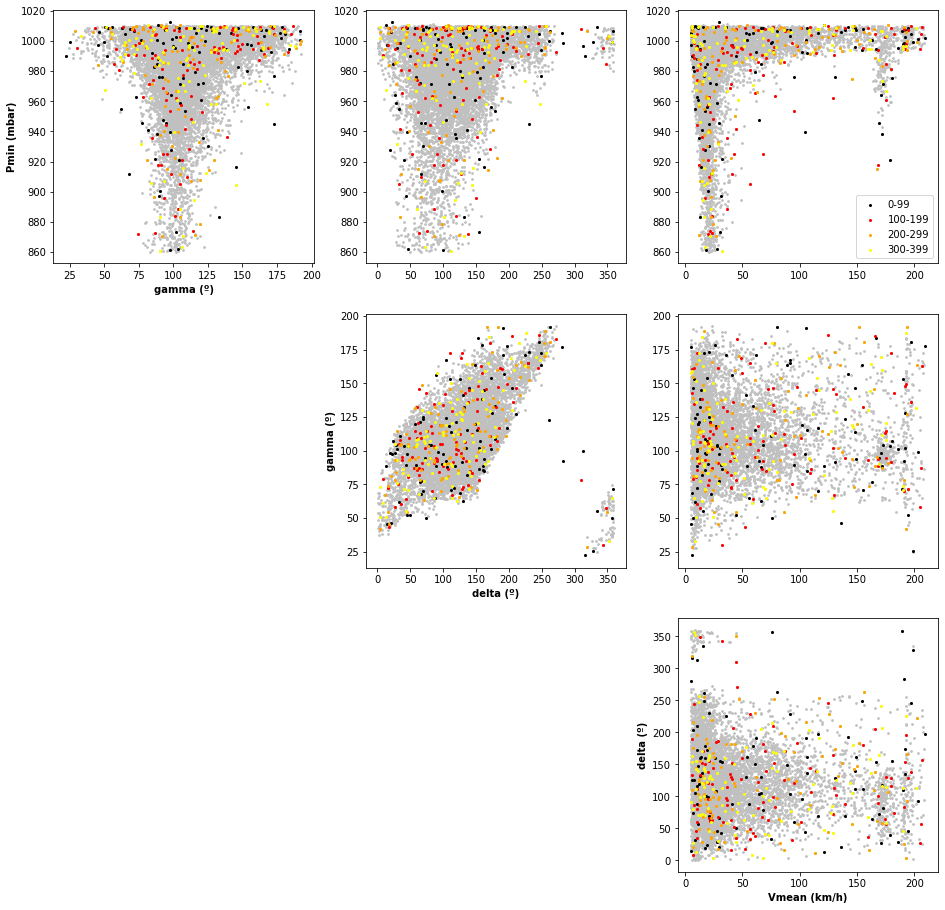

In [7]:
# Historical vs Simulated: scatter plot parameters
Plot_Params_MDA_vs_Sim_scatter(xds_TCs_r2_MDA_params, xds_TCs_r2_params)


## Nakajo TCs (MDA centroids) Waves Simulation

Waves data is generated by numerically simulating selected storms. 

This methodology is not included inside teslakit python library.

This step needs to be done before continuing with notebook 05
